In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [65]:
cirs = np.load('cirs_noised_ld.npy')
cirs_obs = np.load('cirs_observation_ld.npy')
triplets = np.load('triplets_ld.npy')

In [77]:
miu, sigma = cirs.mean(), cirs.var()

cirs_1 = (cirs - cirs.min()) / (cirs.max() - cirs.min())
cirs_obs = (cirs_obs - cirs_obs.min()) / (cirs_obs.max() - cirs_obs.min())

In [24]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [73]:
cirs_nmlz = normalize_complex_arr(cirs)

In [71]:
def normalize_complex_arr(a):
    a_oo = a - a.real.min() - 1j*a.imag.min() # origin offsetted
    return a_oo/np.abs(a_oo).max()

In [78]:
np.mean(cirs_nmlz), np.mean(cirs_obs), np.var(cirs_nmlz), np.mean(cirs_1)

((0.2556390004552904+0.3184656954349718j),
 (0.5046122225590033+0.1656954258411093j),
 0.00024638296808287657,
 (0.28381297932267213-0.11917461734366161j))

In [7]:
P = np.array([cirs_obs[trp[0]] for trp in triplets])
Pi = np.array([cirs[trp[1]] for trp in triplets])
Pj = np.array([cirs[trp[2]] for trp in triplets])

In [8]:
def loss_hinge(p, pi, pj, W, margin=1):
    return max(0, margin - p.T @ W @ pi + p.T @ W @ pj)

def loss_global(triplets, W, cirs, cirs_obs):
    return np.sum([loss_hinge(cirs_obs[i0], cirs[i1], cirs[i2], W) for i0, i1, i2 in triplets])

def gradient(W, P, Pi, Pj):
    grad = np.zeros_like(W)

def gradient_descent():
    ...

## Triplet loss with Keras

In [99]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, Flatten, Input, Dense, LayerNormalization, Dropout, Concatenate
from tensorflow.keras.layers import Lambda, Dot
from tensorflow.keras.regularizers import l2
from keras.callbacks import History 
from keras import backend as K

In [86]:
import tensorflow as tf
from sklearn.metrics import roc_auc_score
from tensorflow.keras import layers


def identity_loss(y_true, y_pred):
    """Ignore y_true and return the mean of y_pred
    
    This is a hack to work-around the design of the Keras API that is
    not really suited to train networks with a triplet loss by default.
    """
    return tf.reduce_mean(y_pred)


class MarginLoss(layers.Layer):

    def __init__(self, margin=1):
        super().__init__()
        self.margin = margin
        
    def call(self, inputs):
        pos_pair_similarity = inputs[0]
        neg_pair_similarity = inputs[1]
        
        diff = neg_pair_similarity - pos_pair_similarity
        return tf.maximum(diff + self.margin, 0.)
    

def average_roc_auc(model, data_train, data_test):
    """Compute the ROC AUC for each user and average over users"""
    max_user_id = max(data_train['user_id'].max(),
                      data_test['user_id'].max())
    max_item_id = max(data_train['item_id'].max(),
                      data_test['item_id'].max())
    user_auc_scores = []
    for user_id in range(1, max_user_id + 1):
        pos_item_train = data_train[data_train['user_id'] == user_id]
        pos_item_test = data_test[data_test['user_id'] == user_id]
        
        # Consider all the items already seen in the training set
        all_item_ids = np.arange(1, max_item_id + 1)
        items_to_rank = np.setdiff1d(
            all_item_ids, pos_item_train['item_id'].values)
        
        # Ground truth: return 1 for each item positively present in
        # the test set and 0 otherwise.
        expected = np.in1d(
            items_to_rank, pos_item_test['item_id'].values)
        
        if np.sum(expected) >= 1:
            # At least one positive test value to rank
            repeated_user_id = np.empty_like(items_to_rank)
            repeated_user_id.fill(user_id)

            predicted = model.predict(
                [repeated_user_id, items_to_rank], batch_size=4096)
        
            user_auc_scores.append(roc_auc_score(expected, predicted))

    return sum(user_auc_scores) / len(user_auc_scores)

In [87]:
def sample_triplets(triplets, cir_obs, cir_base, random_seed=0):
    obs, pos_comp, neg_comp = [], [], []
    rng = np.random.RandomState(random_seed)
    for i, j, _ in triplets:
        obs.append(cir_obs[i])
        pos_comp.append(cir_base[j])

    neg_comp = cir_base[rng.randint(low=0, high=len(cirs), size=len(triplets))]

    return [np.array(obs), np.array(pos_comp), np.array(neg_comp)]

In [93]:
class TripletModel(Model):
    def __init__(self, n_observation, n_comparison, margin=1., latent_dim=64, l2_reg=None):
        super().__init__(name="TripletModel")
        
        self.margin = margin
        
        l2_reg = None if l2_reg == 0 else l2(l2_reg)
        # self.obs_layer = Embedding(n_observation, n_observation,
        #                             name='obs_embedding',
        #                             embeddings_regularizer=l2_reg)
        # self.comp_layer = Embedding(n_comparison, n_comparison,
        #                     name='comp_embedding',
        #                     embeddings_regularizer=l2_reg)
        self.normalization = LayerNormalization()

        self.dot = Dot(axes=1, normalize=True)

        self.margin_loss = MarginLoss(margin)

        self.dense_1 = Dense(latent_dim, activation='relu')
        self.dense_2 = Dense(latent_dim, activation='relu')
        
    def call(self, inputs, training=False):
        # observation = inputs[0]
        # pos_compare = inputs[1]
        # neg_compare = inputs[2]
        
        # obs_input = self.obs_layer(observation)
        
        # pos_input = self.comp_layer(pos_compare)
        
        # neg_input = self.comp_layer(neg_compare)
        obs_input, pos_input, neg_input = inputs[0], inputs[1], inputs[2]

        # self.normalization.adapt(obs_input)
        obs_nmlz = self.normalization(obs_input)
        pos_nmlz = self.normalization(pos_input)
        neg_nmlz = self.normalization(neg_input)

        # latent feature
        obs = self.dense_1(obs_nmlz)
        pos = self.dense_2(pos_nmlz)
        neg = self.dense_2(neg_nmlz)
        
        # Similarity computation between embeddings
        pos_similarity = self.dot([obs, pos])
        neg_similarity = self.dot([obs, neg])
                
        return self.margin_loss([pos_similarity, neg_similarity])

In [94]:
history = History()

In [95]:
fake_y = np.ones(len(cirs))

dim_obs = cirs_obs.shape[1]
dim_comp = cirs.shape[1]

triplet_model = TripletModel(dim_obs, dim_comp, l2_reg=1e-6, margin=1)

triplet_model.compile(loss=identity_loss, optimizer="adam")

n_epochs = 100
batch_size = 64

for i in range(n_epochs):
    # Sample new negatives to build different triplets at each epoch
    triplet_inputs = sample_triplets(triplets, cirs_obs, cirs, random_seed=i)

    # Fit the model incrementally by doing a single pass over the
    # sampled triplets.
    triplet_model.fit(x=triplet_inputs, y=fake_y, shuffle=True,
                      batch_size=32, epochs=1, callbacks=[history])

13/13 [==============================] - 0s 2ms/step - loss: 1.0000


In [96]:
triplet_model.summary()

Model: "TripletModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer_normalization_1 (Laye  multiple                 1350      
 rNormalization)                                                 
                                                                 
 dot_15 (Dot)                multiple                  0         
                                                                 
 margin_loss_15 (MarginLoss)  multiple                 0         
                                                                 
 dense_35 (Dense)            multiple                  43264     
                                                                 
 dense_36 (Dense)            multiple                  43264     
                                                                 
Total params: 87,878
Trainable params: 87,878
Non-trainable params: 0
__________________________________________________

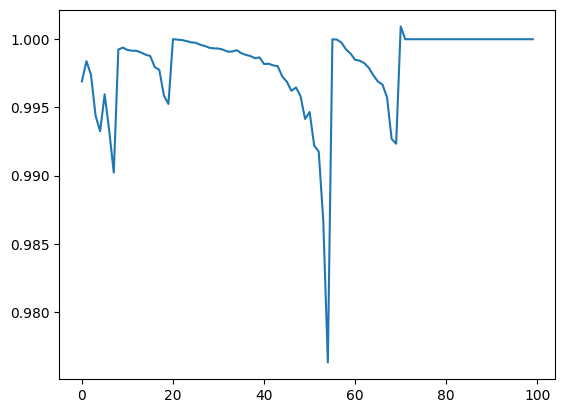

In [97]:
plt.plot(history.history['loss'][-100:])

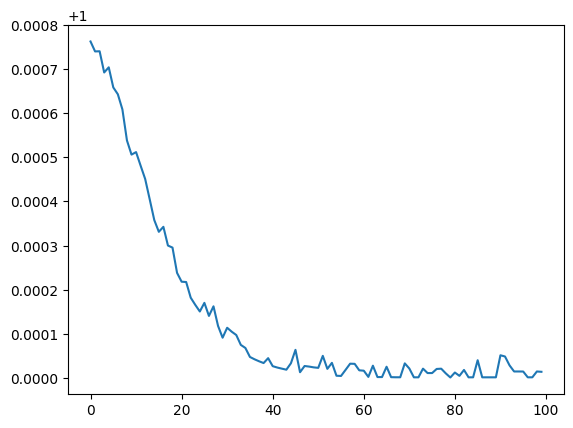

In [20]:
plt.plot(history.history['loss'])

In [104]:
class MLP(layers.Layer):
    def __init__(self, n_hidden=1, hidden_size=64, dropout=0.,
                 l2_reg=None):
        super().__init__()

        # self.layers = [Dropout(dropout)]
        self.layers=[]

        for _ in range(n_hidden):
            self.layers.append(Dense(hidden_size, activation="relu",
                                     kernel_regularizer=l2_reg))
            # self.layers.append(Dropout(dropout))

        self.layers.append(Dense(1, activation="relu",
                                 kernel_regularizer=l2_reg))

    def call(self, x, training=False):
        for layer in self.layers:
            if isinstance(layer, Dropout):
                x = layer(x, training=training)
            else:
                x = layer(x)
        return x
    

class DeepTripletModel(Model):
    def __init__(self, n_users, n_items, user_dim=32, item_dim=64, margin=1.,
                 n_hidden=1, hidden_size=64, dropout=0, l2_reg=None):
        super().__init__()

        l2_reg = None if l2_reg == 0 else l2(l2_reg)

        self.flatten = Flatten()
        self.concat = Concatenate()

        self.mlp = MLP(n_hidden, hidden_size, dropout, l2_reg)

        self.margin_loss = MarginLoss(margin)

    def call(self, inputs):
        obs = inputs[0]
        pos = inputs[1]
        neg = inputs[2]

        # Similarity computation between embeddings
        pos_embeddings_pair = self.concat([obs, pos])
        neg_embeddings_pair = self.concat([obs, neg])

        pos_similarity = self.mlp(pos_embeddings_pair)
        neg_similarity = self.mlp(neg_embeddings_pair)

        return self.margin_loss([pos_similarity, neg_similarity])

In [103]:
mlp = MLP()

In [105]:
hyper_parameters = dict(
    user_dim=32,
    item_dim=64,
    n_hidden=1,
    hidden_size=128,
    dropout=0.1,
    l2_reg=0.,
)
deep_triplet_model = DeepTripletModel(dim_obs, dim_comp,
                                      **hyper_parameters)

deep_triplet_model.compile(loss=identity_loss, optimizer='adam')
# fake_y = np.ones_like(pos_data_train['user_id'])

In [106]:
deep_triplet_model.fit(triplet_inputs, fake_y)

13/13 [==============================] - 0s 2ms/step - loss: 1.0000


In [107]:
for i in range(n_epochs):
    # Sample new negatives to build different triplets at each epoch
    triplet_inputs = sample_triplets(triplets, cirs_obs, cirs, random_seed=i)

    # Fit the model incrementally by doing a single pass over the
    # sampled triplets.
    deep_triplet_model.fit(x=triplet_inputs, y=fake_y, shuffle=True,
                      batch_size=32, epochs=1, callbacks=[history])

13/13 [==============================] - 0s 3ms/step - loss: 1.0000


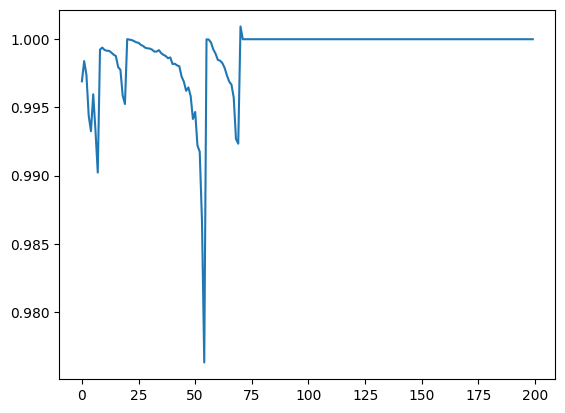

In [108]:
plt.plot(history.history['loss'])